# CHATBOT PARA CONSULTAS DE TECNICOS EN INSTALACIONES DE SISTEMA SONAR - PARTE 2
En esta segunda parte, realizaremos la descarga del modelo, lo probaremos y haremos un fine-tuning con los datos de entranamiento para luego probarlo.
Tambien mostraremos datos de entrenamiento y ejecutaremos streamlit para usar una interfaz grafica con el modelo.

Hemos utilizado el modelo T5 dado que ofrece mejor rendiemiento al Salamandra 2B. Aun asi podriamos mejorar el modelo teniendo mas datos de entrenamiento

In [1]:
!pip install transformers accelerate bitsandbytes datasets peft torch streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments
import torch

model_name = "google-t5/t5-base"

# Cargamos el modelo y tokenizador y probamos el modelo de base
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.pad_token_id

def generate_respuesta(prompt, max_length=256, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_p=0.95,
        num_return_sequences=1
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

prompt_example = "Responde de manera clara y detallada.Pregunta: ¿Cómo se basa el sistema de Guiado de Equinsa Parking en la detección de vehículos?\nRespuesta:"
print("=== Salida del modelo ANTES del entrenamiento ===")
print(generate_respuesta(prompt_example))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

=== Salida del modelo ANTES del entrenamiento ===
Cómo se basa el sistema de Guiado de Equinsa Parking en la detección de vehculos?


In [3]:
from datasets import load_dataset

# borramos el modelo y limpiamos la cache
del model
torch.cuda.empty_cache()

# Volvemos a cargar el modelo
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map="auto")
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.pad_token_id

# Cargar el dataset
dataset = load_dataset("json", data_files={"train": "./qa_dataset_mejorado.json"})

# Función de tokenización: se preparan entradas y etiquetas para el entrenamiento
def funcion_tokenizacion(examples):
    inputs = [f"Pregunta: {p}\nRespuesta:" for p in examples["pregunta"]]
    targets = examples["respuesta"]
    model_inputs = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, truncation=True, padding="max_length", max_length=128)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(
    funcion_tokenizacion,
    batched=True,
    remove_columns=dataset["train"].column_names
)

# configuramos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./T5-finetuned",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_steps=500,
    eval_strategy="no",
    save_total_limit=2,
    remove_unused_columns=False
)

# se inicializa el trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"]
)

# inicia el entrenamiento
trainer.train()

# guardamos el modelo entrenado
model.save_pretrained("./T5-finetuned")
tokenizer.save_pretrained("./T5-finetuned") # Save the tokenizer along with the model

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manuelabosmaria (manuelabosmaria-mi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,12.524800
20,4.227000
30,3.498500
40,3.744300
50,3.252100
60,3.166700
70,3.446300
80,3.400700


('./T5-finetuned/tokenizer_config.json',
 './T5-finetuned/special_tokens_map.json',
 './T5-finetuned/spiece.model',
 './T5-finetuned/added_tokens.json',
 './T5-finetuned/tokenizer.json')

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# ruta del modelo
finetuned_model_path = "./T5-finetuned"

# cargamos el modelo re entrenado
model = AutoModelForSeq2SeqLM.from_pretrained(finetuned_model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)

# verificamos que este configurado el tokenizador
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.pad_token_id

# Función para generar respuestas con el modelo fine-tuneado
def generate_respuesta(prompt, max_length=256, temperature=0.4):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_p=0.95,
        num_return_sequences=1
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [5]:
# prompt prueba
prompt_example = "Pregunta: Responde de manera clara y detallada. ¿Cómo funciona el sistema de Guiado de Equinsa Parking?\nRespuesta:"

# generamos respuestas
respuesta = generate_respuesta(prompt_example)
print("=== Respuesta del modelo entrenado ===")
print(respuesta)


=== Respuesta del modelo entrenado ===
El sistema de Guiado de Equinsa Parking se encuentra en una manera clara y detallada.


In [6]:
prompt_example = "Pregunta: ¿Cuál es la función de la sonda de detección en el sistema?\nRespuesta:"

# generamos respuestas
respuesta = generate_respuesta(prompt_example)
print("=== Respuesta del modelo entrenado ===")
print(respuesta)

=== Respuesta del modelo entrenado ===
La sonda de detección es una opción de cada vez el sistema de detección y detección del ttulo de las sondas de detección.


## ESTADISTICAS DEL MODELO CON WANDB
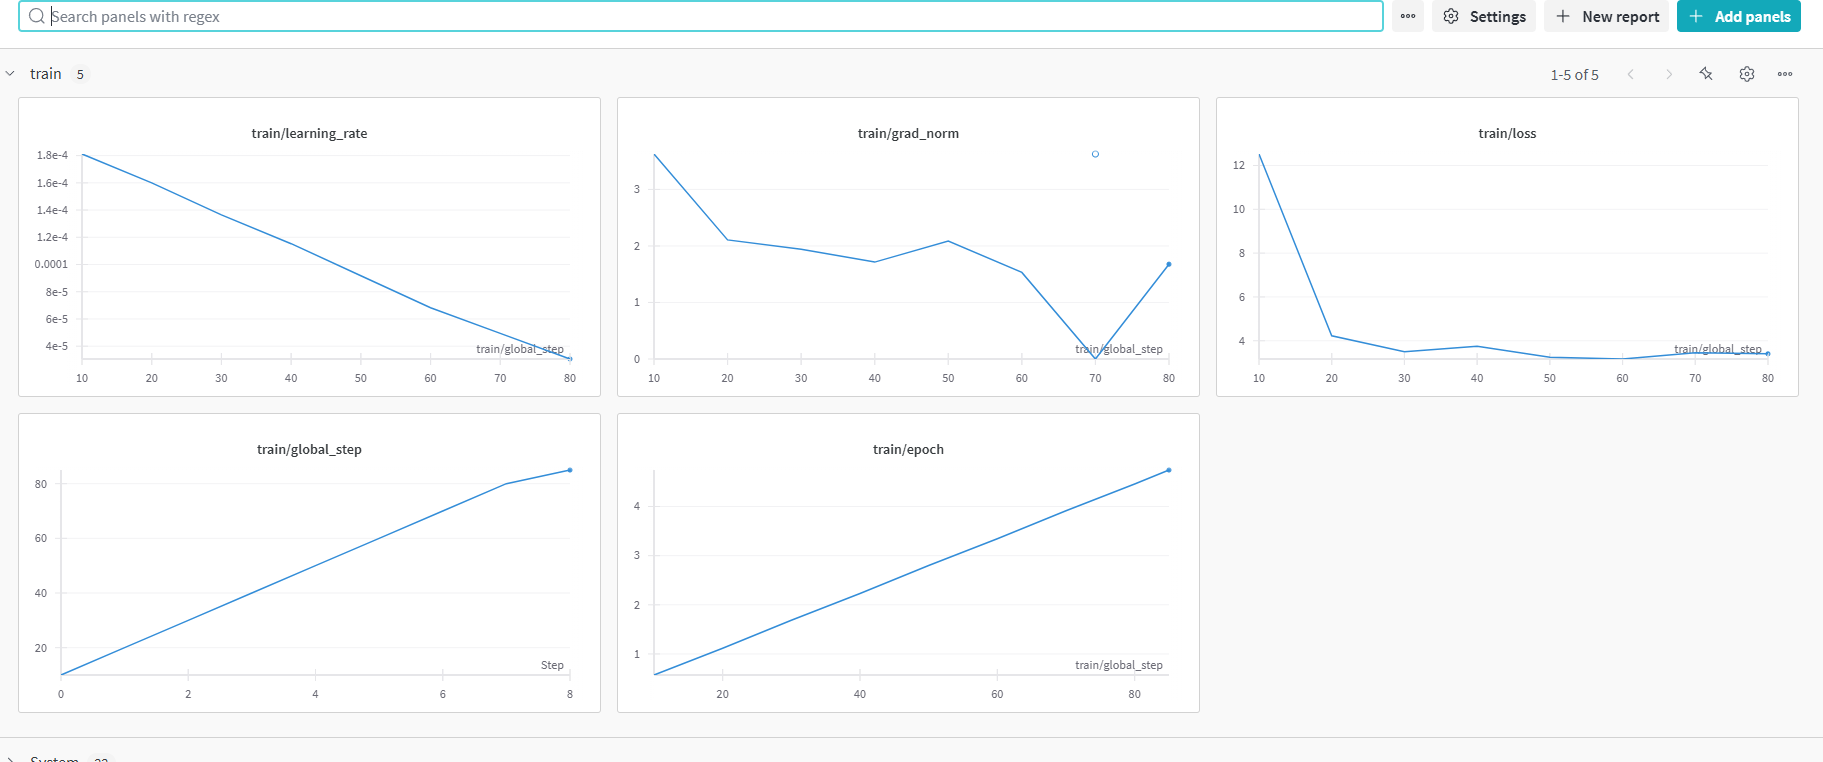

## INTERFAZ STREAMLIT
Implementamos streamlit para crear una interfraz grafica

In [7]:
%%writefile app.py
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

@st.cache_resource(show_spinner=False)
def load_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("./T5-finetuned")
    model = AutoModelForSeq2SeqLM.from_pretrained(
        "./T5-finetuned",
        device_map="auto",
        torch_dtype=torch.float16
    )
    return tokenizer, model

tokenizer, model = load_model_and_tokenizer()

st.title("Chatbot para resolucion de incidencias de tecnicos de EQUINSA PARKING ")

if "chat_history" not in st.session_state:
    st.session_state.chat_history = ""

user_input = st.text_input("Escribe tu pregunta:")

def generar_respuesta(prompt, max_length=256, temperature=0.7, top_p=0.95):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        num_return_sequences=1
    )
    response_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return response_text

if st.button("Enviar"):
    prompt = f"\nUsuario: {user_input}\nChatbot:"
    output = generar_respuesta(prompt)
    if "Chatbot:" in output:
        response = output.split("Chatbot:")[-1].strip()
    else:
        response = output.strip()
    st.session_state.chat_history += f"\nUsuario: {user_input}\nChatbot: {response}"


st.text_area("Conversación", st.session_state.chat_history, height=400)


Writing app.py


In [8]:
!ngrok config add-authtoken XXX

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [9]:
from pyngrok import ngrok

public_url = ngrok.connect(8501)
print("Streamlit URL:", public_url)

# ejecutamos la app
!streamlit run app.py &

Streamlit URL: NgrokTunnel: "https://4a0e-35-198-208-62.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.198.208.62:8501



2025-02-02 19:35:17.577782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738524917.602432    3160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738524917.609800    3160 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 19:35:23.117 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registered via torch::class_
2025-02-02 19:35:42.244 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registered via torch::class_
  Stopping...


#INTERFAZ
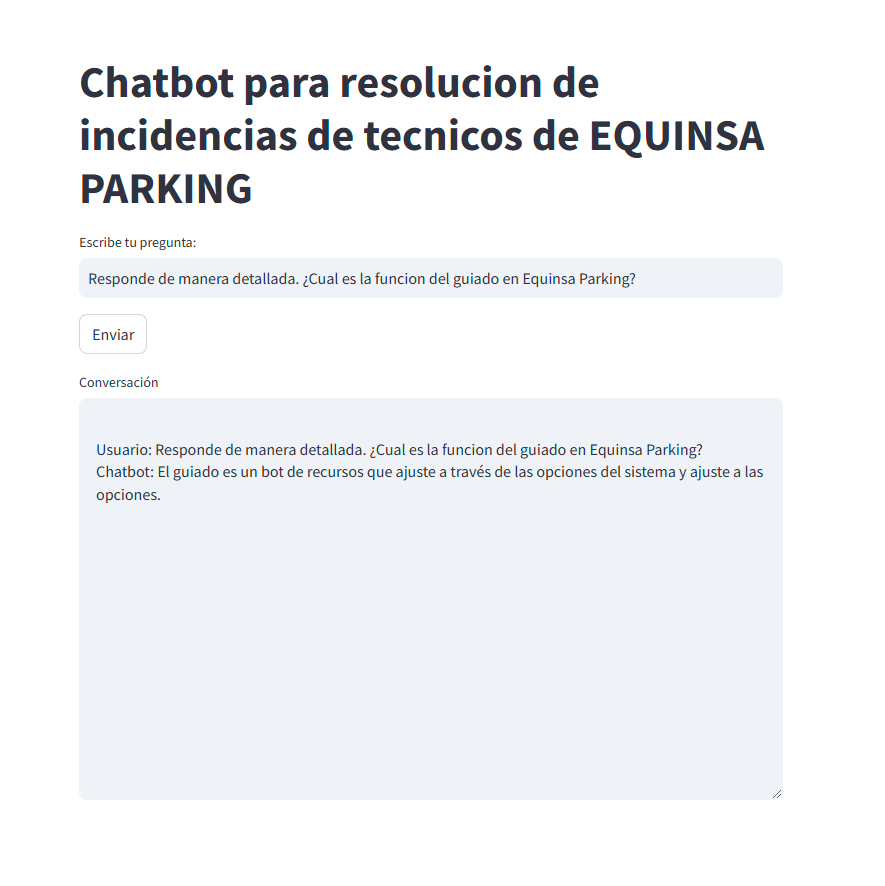